In [ ]:
#Importing useful Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)


2.15.0


In [ ]:
#Download and show dataset

11490434/11490434 [==============================] - 15s 1us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


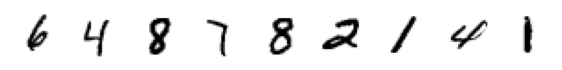

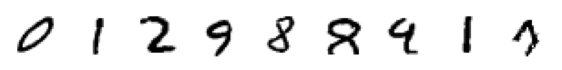

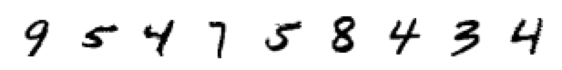

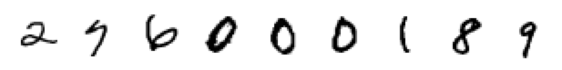

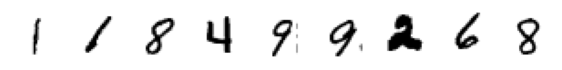

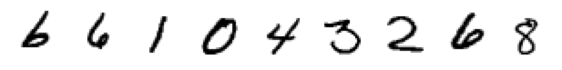

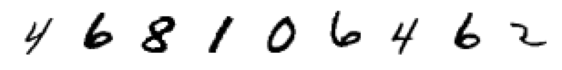

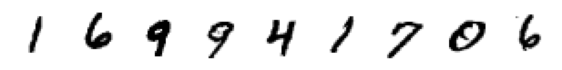

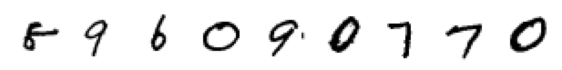

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))


for k in range(9):
    plt.figure(figsize=(7, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

In [ ]:
#Data Normalization

In [4]:
trainX = [image/255.0 for image in trainX]
testX = [image/255.0 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


In [ ]:
#Generator Network

In [5]:
random_input = tensorflow.keras.layers.Input(shape = 50)

x = tensorflow.keras.layers.Dense(1200, activation='relu')(random_input)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Dense(1000, activation='relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Dense(28*28)(x)
x = tensorflow.keras.layers.Reshape((28, 28, 1))(x)

generated_image = tensorflow.keras.layers.Activation('sigmoid')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 1200)              61200     
                                                                 
 batch_normalization (Batch  (None, 1200)              4800      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1000)              1201000   
                                                                 
 batch_normalization_1 (Bat  (None, 1000)              4000      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 784)               78478

In [ ]:
#Discriminator Network

In [6]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Flatten()(image_input)
x = tensorflow.keras.layers.Dense(256, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.3)(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.5)(x)
x = tensorflow.keras.layers.Dense(1)(x)

real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129 

In [13]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [ ]:
#GAN, Defining combined model

In [14]:
discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

gan_model = tensorflow.keras.models.Model(random_input, d_output)
gan_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         2055784   
                                                                 
 model_1 (Functional)        (None, 1)                 233985    
                                                                 
Total params: 2289769 (8.73 MB)
Trainable params: 2051384 (7.83 MB)
Non-trainable params: 238385 (931.19 KB)
_________________________________________________________________


In [ ]:
#Compiling GAN

In [15]:
gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

In [ ]:
#Define Data Generators

In [16]:
# Indices of Zero Images
indices = [i for i in range(len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[j,:,:,-1], cmap='gray_r')
            plt.axis('off')
            #plt.title(trainY[i])
        plt.show()
    return

In [ ]:
#Training GAN

In [ ]:
epochs = 200
batch_size = 100
steps = 500
noise_size = 50

losses_d = []
losses_g = []

for i in range(0, epochs):
    if (i%10 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)

        losses_d.append(loss_d[0])
        losses_g.append(loss_g)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))

In [ ]:
#Show Results

In [ ]:
#Generating Unlimited samples
for i in range(5):
    show_generator_results(generator_network)